In [2]:
import os
import gc
import parse
import logging
import numpy as np
import pandas as pd
from typing import List

from utils import get_N_tokens, read_and_split_file, raw_dir, interim_dir, final_dir, load_SET_dataset

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

# Generating train dataset and splitting it in train and test

In [12]:
texts, labels = list(), list()

files = ["bswac_tail_pp", "cnrwac_tail_pp", "hrwac_tail_pp", "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})


from sklearn.model_selection import train_test_split

train, eval_df = train_test_split(train, test_size=0.1, stratify=train.labels)


In [5]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()


def get_stats(N: int, train=train, eval_df=eval_df, clf=clf):
    import gc
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics import (
        f1_score,
        ConfusionMatrixDisplay,
        confusion_matrix,
        accuracy_score,
    )

    gc.collect()
    vocabulary = get_N_tokens(N)

    def get_coverage(s:str) -> int:
        """Calculates how many vocabulary tokens are in the string.

        Args:
            s (str): input string

        Returns:
            int: number of DISTINCT vocabulary tokens in input string.
        """        
        word_set = set(s.split(" "))
        return len(word_set.intersection(vocabulary))
    vectorizer = CountVectorizer(vocabulary=vocabulary, lowercase=True, binary=True)
    
    eval_df["coverage"] = eval_df.text.apply(get_coverage)
    average_coverage = eval_df.coverage.mean()


    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels
    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels


    clf.fit(train_vectors.toarray(), train_labels)
    y_pred = clf.predict(test_vectors.toarray())

    LABELS = ["hr", "bs", "sr", "me"]

    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS, average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    return {"N": N, "microF1": micro, "macroF1": macro, "accuracy": acc, "cm": cm,
    "coverage": average_coverage}


{'c'}

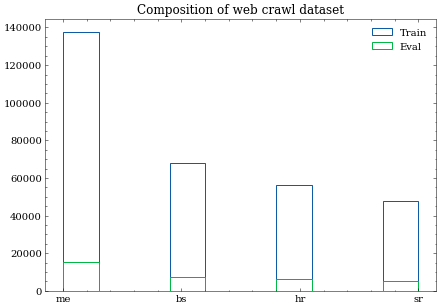

In [17]:
import matplotlib.pyplot as plt
plt.style.use("science,no-latex".split(","))
plt.figure(figsize=(7,5))
plt.hist(train.labels, histtype="step", label="Train")
plt.hist(eval_df.labels, histtype="step", label="Eval")
plt.legend()
plt.title("Composition of web crawl dataset")
plt.savefig("images/17_composition.png")
plt.show()

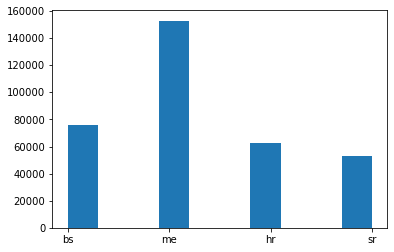

In [13]:
plt.hist(labels)
plt.show()